## Is the air clean?
Can we use deep learning to detect if the air is clean? Better yet, can we tell the AQI through an image of a skyline?

> During covid lockdown, people as far as 200 KMs from Himalayas, we able to see the mountains through their roofs. The phenomenon is made possible by a dramatic improvement in air quality in recent weeks, after industries shut down, cars came off the road and airlines canceled flights in response to the coronavirus pandemic.

Source: https://edition.cnn.com/travel/article/himalayas-visible-lockdown-india-scli-intl/index.html

In this notebook, we will try to build a model that can predict if the air is clean or polluted looking at an image of a skyline.

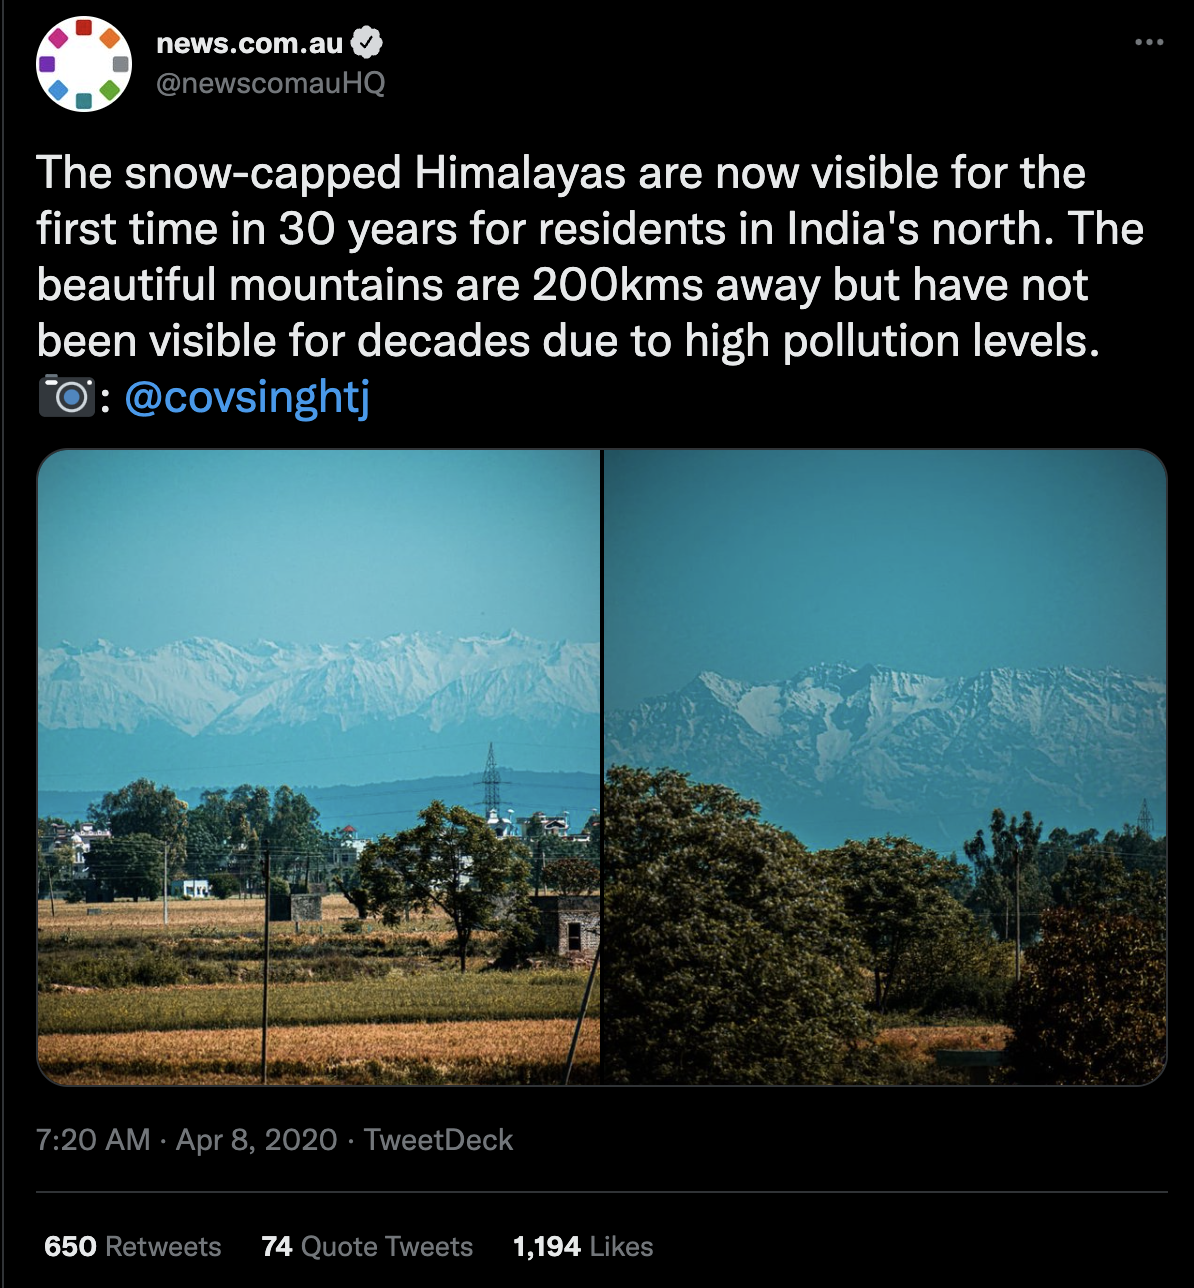

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "clean air skyline" and "polluted air skyline"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a skyline and see if it can differential between clean and polluted air

## Step 1: Download images of clean and polluted air skylines

In [2]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a clean air skyline photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [2]:
urls = search_images('clean air skyline', max_images=10)
urls[0]

'https://cdn.vox-cdn.com/thumbor/OGZUbbciv8bBOq5k26Usp5_A-3A=/0x0:7360x4912/1200x800/filters:focal(3092x1868:4268x3044)/cdn.vox-cdn.com/uploads/chorus_image/image/65446502/shutterstock_424737244.0.0.jpg'

...and then download a URL and take a look at it:

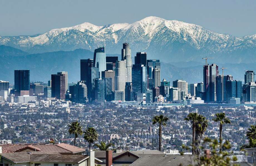

In [3]:
from fastdownload import download_url
dest = 'skyline.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

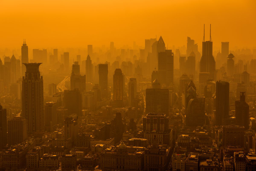

In [4]:
download_url(search_images('polluted air skyline', max_images=1)[0], 'polluted air skyline.jpg', show_progress=False)
Image.open('polluted air skyline.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [5]:
searches = 'clean air skyline','polluted air skyline'
path = Path('clean_air_or_not')
from time import sleep

In [24]:
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} aqi'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} buildings'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

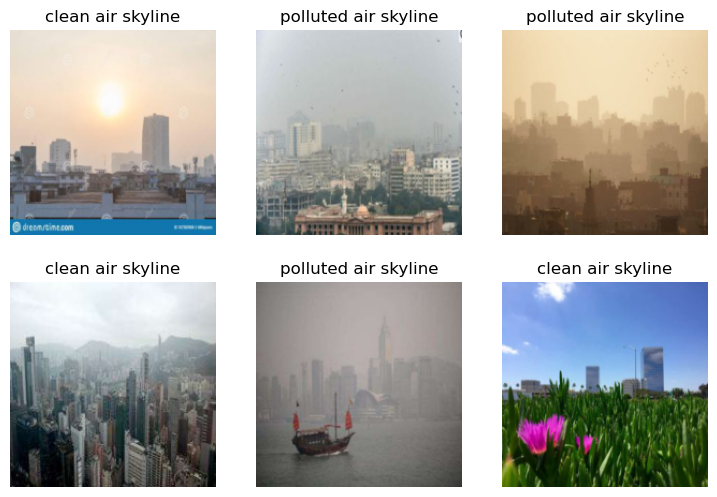

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.177682,0.695176,0.279279,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.721189,0.545226,0.225225,00:03
1,0.557955,0.633590,0.220721,00:02
2,0.437643,0.617223,0.229730,00:02


## Data Cleaning
Data cleaning is an important step in this project because of bais in coverage of air pollution. Even if you search to neutral topics like air quality, you'll find more media cover

In [9]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [10]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that skyline we downloaded at the start:

In [13]:
is_clean,_,probs = learn.predict(PILImage.create('polluted air skyline.jpg'))

print(f"This is a: {is_clean}.")
print(f"Probability it's clean air: {probs[0]:.4f}")

This is a: polluted air skyline.
Probability it's clean air: 0.0006


In [41]:
learn.export('pollution_model.pkl')

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.